# Create one (1) area-weighted forcing file
We need to find how the ERA5 gridded forcing maps onto the catchment to create area-weighted forcing as SUMMA input. This involves two steps:
1. Intersect the ERA5 shape with the user's catchment shape to find the overlap between a given (sub) catchment and the forcing grid;
2. Create an area-weighted, catchment-averaged forcing time series.

The CANDEX package (https://github.com/ShervanGharari/candex_newgen) provides the necessary functionality to do this. CANDEX performs the GIS step (1, shapefile intersection) and the area-weighting step (2, create new forcing `.nc` files) as part of a single `run_candex()` call. To allow for parallelization, CANDEX can save the output from the GIS step into a restart `.csv` file which can be used to skip the GIS step. This allows (manual) parallelization of area-weighted forcing file generation after the GIS procedures have been run once. The full workflow here is thus:
1. [This script] Call `run_candex()` with ERA5 and user's shapefile, and one ERA5 forcing `.nc` file;
    - CANDEX performs intersection of both shapefiles;
    - CANDEX saves the outcomes of this intersection to a `.csv` file;
    - CANDEX creates an area-weighted forcing file from a single provided ERA5 source `.nc` file
2. [Follow-up script] Call `run_candex()` with intersection `.csv` file and all other forcing `.nc` files.
3. [Follow-up script] Apply lapse rates to temperature variable.

Parallelization of step 2 (2nd `run_candex()` call) requires an external loop that sends (batches of) the remaining ERA5 raw forcing files to individual processors. As with other steps that may be parallelized, creating code that does this is left to the user.



In [1]:
# modules
import os
import glob
import candex
from pathlib import Path
from shutil import rmtree
from shutil import copyfile
from datetime import datetime

#### Control file handling



In [2]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line:
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find location of shapefiles

In [6]:
# Catchment shapefile path & name
catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

In [7]:
# Specify default path if needed
if catchment_path == 'default':
    catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    catchment_path = Path(catchment_path) # make sure a user-specified path is a Path()

In [8]:
# Forcing shapefile path & name
forcing_path = read_from_control(controlFolder/controlFile,'forcing_shape_path')
forcing_name = read_from_control(controlFolder/controlFile,'forcing_shape_name')

In [9]:
# Specify default path if needed
if forcing_path == 'default':
    forcing_path = make_default_path('shapefiles/forcing') # outputs a Path()
else:
    forcing_path = Path(forcing_path) # make sure a user-specified path is a Path()

#### Find where the intersection needs to go

In [10]:
# Intersected shapefile path and name
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')
intersect_name = read_from_control(controlFolder/controlFile,'intersect_forcing_name')
intersect_csv  = read_from_control(controlFolder/controlFile,'intersect_forcing_csv_name')

In [11]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [12]:
# Make the folder if it doesn't exist
intersect_path.mkdir(parents=True, exist_ok=True)

#### Find the forcing files (merged ERA5 data)

In [13]:
# Location of merged ERA5 files
forcing_merged_path = read_from_control(controlFolder/controlFile,'forcing_merged_path')

In [14]:
# Specify default path if needed
if forcing_merged_path == 'default':
    forcing_merged_path = make_default_path('forcing/2_merged_data') # outputs a Path()
else:
    forcing_merged_path = Path(forcing_merged_path) # make sure a user-specified path is a Path()

In [15]:
# Find files in folder
forcing_files = [forcing_merged_path/file for file in os.listdir(forcing_merged_path) if os.path.isfile(forcing_merged_path/file)]

In [16]:
# Sort the files
forcing_files.sort()

#### Find where the temporary CANDEX files need to go

In [17]:
# Location for CANDEX temporary storage
forcing_candex_path = read_from_control(controlFolder/controlFile,'forcing_candex_path')

In [18]:
# Specify default path if needed
if forcing_candex_path == 'default':
    forcing_candex_path = make_default_path('forcing/3_temp_candex') # outputs a Path()
else:
    forcing_candex_path = Path(forcing_candex_path) # make sure a user-specified path is a Path()

In [19]:
# Make the folder if it doesn't exist
forcing_candex_path.mkdir(parents=True, exist_ok=True)

#### Find where the area-weighted forcing needs to go

In [20]:
# Location for SUMMA-ready files
forcing_basin_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [21]:
# Specify default path if needed
if forcing_basin_path == 'default':
    forcing_basin_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_basin_path = Path(forcing_basin_path) # make sure a user-specified path is a Path()

In [22]:
# Make the folder if it doesn't exist
forcing_basin_path.mkdir(parents=True, exist_ok=True)

#### CANDEX

In [23]:
# Initialize a CANDEX object
cndx = candex.candex()

In [24]:
# Author name
cndx.author_name = 'SUMMA public workflow scripts'

In [25]:
# Data license
cndx.license = 'Copernicus data use license: https://cds.climate.copernicus.eu/api/v2/terms/static/licence-to-use-copernicus-products.pdf'

In [26]:
# Case name, used in CANDEX-generated file naes
cndx.case_name = read_from_control(controlFolder/controlFile,'domain_name')

In [27]:
# ERA5 shapefile and variable names
# Variable names can be hardcoded because we set them when we generate this shapefile as part of the workflow
cndx.source_shp     = forcing_path/forcing_name # shapefile
cndx.source_shp_lat = 'lat'                     # name of the latitude field
cndx.source_shp_lon = 'lon'                     # name of the longitude field

In [28]:
# Catchment shapefile and variable names
cndx.sink_shp = catchment_path/catchment_name
cndx.sink_shp_ID  = read_from_control(controlFolder/controlFile,'catchment_shp_hruid') # name of the HRU ID field
cndx.sink_shp_lat = read_from_control(controlFolder/controlFile,'catchment_shp_lat')   # name of the latitude field
cndx.sink_shp_lon = read_from_control(controlFolder/controlFile,'catchment_shp_lon')   # name of the longitude field

In [29]:
# ERA5 netcdf file and variable names
cndx.source_nc = str(forcing_files[0]) # first file in the list; Path() to string
cndx.var_names = ['airpres',
                  'LWRadAtm',
                  'SWRadAtm',
                  'pptrate',
                  'airtemp',
                  'spechum',
                  'windspd'] # variable names of forcing data - hardcoded because we prescribe them during ERA5 merging
cndx.var_lat   = 'latitude'  # name of the latitude dimensions
cndx.var_lon   = 'longitude' # name of the longitude dimension
cndx.var_time  = 'time'      # name of the time dimension

In [30]:
# Temporary folder where the CANDEX-generated GIS files and remapping file will be saved
cndx.temp_dir = str(forcing_candex_path) + '/' # Path() to string; ensure the trailing '/' CANDEX wants

In [31]:
# Output folder where the catchment-averaged forcing will be saved
cndx.output_dir = str(forcing_basin_path) + '/' # Path() to string; ensure the trailing '/' CANDEX wants

In [32]:
# Netcdf settings
cndx.remapped_dim_id = 'hru'     # name of the non-time dimension; prescribed by SUMMA
cndx.remapped_var_id = 'hruId'   # name of the variable associated with the non-time dimension
cndx.format_list     = ['f4']    # variable type to save forcing as. Single entry here will be used for all variables
cndx.fill_value_list = ['-9999'] # fill value

In [33]:
# Flag that we do not want the data stored in .csv in addition to .nc
cndx.save_csv  = False

In [34]:
# Flag that we currently have no remapping file
cndx.remap_csv = ''   

In [35]:
# Run candex
cndx.run_candex()

candex is given multiple varibales to be remapped but only on format and fill valuecandex repeat the format and fill value for all the variables in output files
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that the field for ID is provided in sink/target shapefile
candex detects that the field latitude is provided in sink/target shapefile
candex detects that the field longitude is provided in sink/target shapefile
it seems everything is OK with the sink/target shapefile; added to candex object sink_shp_gpd
candex will save standard shapefile for candex claculation as:
C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\forcing\3_temp_candex/BowAtBanff_sink_shapefile.shp
candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['time', 'latitude', 'longitude']
candex detects that the longitude varibales has dimensions of:
['lo

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:109: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2 ['lat_temp'] = shp_2.centroid.y
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2 ['lon_temp'] = shp_2.centroid.x
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:867: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis

------REMAPPING------
Remapping C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\forcing\2_merged_data\ERA5_merged_197901.nc to C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\forcing\3_basin_averaged_data/BowAtBanff_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-03-16 11:06:32.720441
Ended   at date and time 2021-03-16 11:07:06.298799
------


#### Move files to prescribed locations

In [41]:
# Remapping file 
remap_file = cndx.case_name + '_remapping.csv'
copyfile( cndx.temp_dir + remap_file, intersect_path / remap_file);

In [42]:
# Intersected shapefile
for file in glob.glob(cndx.temp_dir + cndx.case_name + '_intersected_shapefile.*'):
    copyfile( file, intersect_path / os.path.basename(file));

In [43]:
# Remove the temporary CANDEX directory to save space
try:
    rmtree(cndx.temp_dir)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))    

#### Checks

In [40]:
# old and new intersection shapes
import geopandas as gpd

In [44]:
shpPath = Path('C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\shapefiles\catchment_intersection\with_forcing')
oldFile = 'catchment_with_era5.shp'
newFile = 'BowAtBanff_intersected_shapefile.shp'

In [45]:
old = gpd.read_file(shpPath/oldFile)
new = gpd.read_file(shpPath/newFile)

In [87]:
# sort both dataframes to be in the same order
old.sort_values(by=['S_1_GRU_ID', 'S_1_HRU_ID','S_2_elev_m'], inplace=True)
new.sort_values(by=['S_1_GRU_ID', 'S_1_HRU_ID','S_2_elev_m'], inplace=True)

In [50]:
checkThese = ['S_1_GRU_ID', 'S_1_HRU_ID', 'S_1_center', 'S_1_cent_1', 'S_1_HRU_ar',
              'S_2_elev_m', 'AS1', 'IDS1', 'S_2_ID', 'AS2', 'IDS2', 'AINT', 'AP1', 
              'AP2', 'AP1N', 'AP2N','geometry' ]

In [88]:
for column in checkThese:
    flag = (new[column].values == old[column].values).all()
    print(column, ': ', flag)

S_1_GRU_ID :  True
S_1_HRU_ID :  True
S_1_center :  True
S_1_cent_1 :  True
S_1_HRU_ar :  True
S_2_elev_m :  True
AS1 :  False
IDS1 :  True
S_2_ID :  True
AS2 :  False
IDS2 :  True
AINT :  False
AP1 :  False
AP2 :  False
AP1N :  False
AP2N :  False
geometry :  False


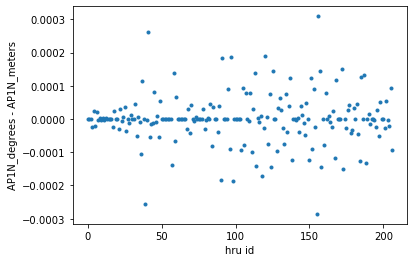

In [114]:
plt.plot(old['AP1N'].values-new['AP1N'].values,linestyle='none',marker='.')
plt.ylabel('AP1N_degrees - AP1N_meters');
plt.xlabel('hru id');

In [93]:
old[['S_1_GRU_ID','S_1_HRU_ID','S_2_elev_m','AS1','AP1N']]

,S_1_GRU_ID,S_1_HRU_ID,S_2_elev_m,AS1,AP1N
0,71028585,48,2020,0.000065,1.000000
1,71028585,97,2020,0.000208,1.000000
2,71028585,118,2020,0.000529,1.000000
3,71028597,1,2020,0.000208,0.466667
17,71028597,1,2169,0.000208,0.533333
...,...,...,...,...,...
205,71032440,47,2243,0.011294,0.916026
141,71032440,47,2258,0.011294,0.004442
186,71032440,47,2284,0.011294,0.054860
206,71032440,96,2243,0.002607,0.729089


In [107]:
old['AP2'].loc[3], old['AP2'].loc[17]

(0.001555555555571, 0.001777777778012)

In [109]:
0.001555555555571 / (0.001555555555571 + 0.001777777778012)

0.4666666666363467

In [108]:
new['AP2'].loc[0], new['AP2'].loc[1]

(0.00155755601498, 0.001779887274927)

In [94]:
new[['S_1_GRU_ID','S_1_HRU_ID','S_2_elev_m','AS1','AP1N']]

,S_1_GRU_ID,S_1_HRU_ID,S_2_elev_m,AS1,AP1N
100,71028585,48,2020,5.081262e+05,1.000000
181,71028585,97,2020,1.615975e+06,1.000000
206,71028585,118,2020,4.117252e+06,1.000000
0,71028597,1,2020,1.620257e+06,0.466691
1,71028597,1,2169,1.620257e+06,0.533309
...,...,...,...,...,...
99,71032440,47,2243,8.694081e+07,0.915973
98,71032440,47,2258,8.694081e+07,0.004447
96,71032440,47,2284,8.694081e+07,0.054882
180,71032440,96,2243,2.007166e+07,0.728997


In [115]:
old = []
new = []

In [36]:
# ID in new forcing files
import xarray as xr

In [37]:
dat = xr.open_dataset(cndx.output_dir + 'BowAtBanff_remapped_1979-01-01-00-00-00.nc' )

In [116]:
dat

<xarray.Dataset>
Dimensions:    (hru: 118, time: 744)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-01-31T23:00:00
Dimensions without coordinates: hru
Data variables:
    latitude   (hru) float64 51.19 51.18 51.19 51.22 ... 51.26 51.37 51.25 51.17
    longitude  (hru) float64 -115.6 -115.7 -115.8 ... -116.1 -115.8 -115.6
    hruId      (hru) float64 1.0 2.0 3.0 4.0 5.0 ... 115.0 116.0 117.0 118.0
    airpres    (time, hru) float32 78926.56 78200.125 ... 76786.43 78322.305
    LWRadAtm   (time, hru) float32 0.0 0.0 0.0 ... 162.9694 163.09486 165.41322
    SWRadAtm   (time, hru) float32 0.0 0.0 0.0 ... 204.34567 200.99901 203.81311
    pptrate    (time, hru) float32 0.0 0.0 0.0 ... 5.2452833e-06 4.0541327e-06
    airtemp    (time, hru) float32 244.60213 243.27028 ... 254.98282 255.83534
    spechum    (time, hru) float32 0.00027762676 0.00027254334 ... 0.0007101003
    windspd    (time, hru) float32 1.2853981 1.0440565 ... 0.8319113 0.30225137
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by SUMMA public workflow scripts
    License:      Copernicus data use license: https://cds.climate.copernicus...
    History:      Created Tue Mar 16 11:06:32 2021
    Source:       Case: BowAtBanff; remapped by script from library of Sherva...

In [117]:
dat.close()

#### Load the shapefiles

In [59]:
import geopandas as gpd

In [109]:
catchment_shape = gpd.read_file( catchment_path/catchment_name )
forcing_shape   = gpd.read_file( forcing_path/forcing_name )

In [110]:
catchment_shape

,GRU_ID,HRU_ID,center_lat,center_lon,HRU_area,geometry
0,71028585,48,51.151817,-115.580275,5.081262e+05,"POLYGON ((-115.57375 51.15042, -115.57375 51.1..."
1,71028585,97,51.160432,-115.575117,1.615975e+06,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554..."
2,71028585,118,51.172348,-115.572209,4.117252e+06,"POLYGON ((-115.58792 51.17708, -115.58792 51.1..."
3,71028597,1,51.192711,-115.622019,1.620257e+06,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854..."
4,71028597,49,51.177476,-115.611405,3.781836e+06,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845..."
...,...,...,...,...,...,...
113,71032409,94,51.639217,-116.148348,5.102856e+06,"MULTIPOLYGON (((-116.17708 51.66042, -116.1754..."
114,71032422,46,51.672291,-116.303021,4.762968e+07,"POLYGON ((-116.34125 51.71542, -116.34042 51.7..."
115,71032422,95,51.647877,-116.323133,3.299651e+06,"POLYGON ((-116.31875 51.63208, -116.31875 51.6..."
116,71032440,47,51.667536,-116.451110,8.694081e+07,"POLYGON ((-116.47042 51.73542, -116.46708 51.7..."


In [37]:
forcing_shape

,ID,lat,lon,elev_m,geometry
0,1.0,51.75,-116.75,2054,"POLYGON ((-116.87500 51.75000, -116.87500 51.8..."
1,2.0,51.50,-116.75,1895,"POLYGON ((-116.87500 51.50000, -116.87500 51.6..."
2,3.0,51.25,-116.75,1757,"POLYGON ((-116.87500 51.25000, -116.87500 51.3..."
3,4.0,51.00,-116.75,1684,"POLYGON ((-116.87500 51.00000, -116.87500 51.1..."
4,5.0,50.75,-116.75,1906,"POLYGON ((-116.87500 50.75000, -116.87500 50.8..."
5,6.0,51.75,-116.50,2243,"POLYGON ((-116.62500 51.75000, -116.62500 51.8..."
6,7.0,51.50,-116.50,2093,"POLYGON ((-116.62500 51.50000, -116.62500 51.6..."
7,8.0,51.25,-116.50,1810,"POLYGON ((-116.62500 51.25000, -116.62500 51.3..."
8,9.0,51.00,-116.50,1637,"POLYGON ((-116.62500 51.00000, -116.62500 51.1..."
9,10.0,50.75,-116.50,1789,"POLYGON ((-116.62500 50.75000, -116.62500 50.8..."


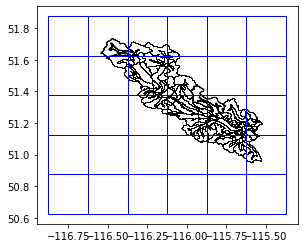

In [15]:
# Check
catchment_shape.plot(facecolor='none',edgecolor='k')
ax = plt.gca()
forcing_shape.plot(ax=ax,facecolor='none',edgecolor='b');

#### Get the intersection function from CANDEX

In [16]:
def intersection_shp(shp_1, shp_2):
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/candex
    @ author's email id:       sh.gharari@gmail.com
    @license:                  Apache2

    This fucntion intersect two shapefile. It keeps the fiels from the first and second shapefiles (identified by S_1_ and 
    S_2_). It also creats other field including AS1 (area of the shape element from shapefile 1), IDS1 (an arbitary index
    for the shapefile 1), AS2 (area of the shape element from shapefile 1), IDS2 (an arbitary index for the shapefile 1), 
    AINT (the area of teh intersected shapes), AP1 (the area of the intersected shape to the shapes from shapefile 1),
    AP2 (the area of teh intersected shape to the shapefes from shapefile 2), AP1N (the area normalized in the case AP1
    summation is not 1 for a given shape from shapefile 1, this will help to preseve mass if part of the shapefile are not 
    intersected), AP2N (the area normalized in the case AP2 summation is not 1 for a given shape from shapefile 2, this
    will help to preseve mass if part of the shapefile are not intersected)
    
    Arguments
    ---------
    shp1: geo data frame, shapefile 1
    shp2: geo data frame, shapefile 2
    
    Returns
    -------
    result: a geo data frame that includes the intersected shapefile and area, percent and normalized percent of each shape
    elements in another one
    """
    # Calculating the area of every shapefile (both should be in degree or meters)
    column_names = shp_1.columns
    column_names = list(column_names)

    # removing the geometry from the column names
    column_names.remove('geometry')

    # renaming the column with S_1
    for i in range(len(column_names)):
        shp_1 = shp_1.rename(
            columns={column_names[i]: 'S_1_' + column_names[i]})

    column_names = shp_2.columns
    column_names = list(column_names)

    # removing the geometry from the colomn names
    column_names.remove('geometry')

    # renaming the column with S_2
    for i in range(len(column_names)):
        shp_2 = shp_2.rename(
            columns={column_names[i]: 'S_2_' + column_names[i]})
        
    # Add the catchment centroids
    shp_1['S_1_lon_c'] = shp_1.centroid.x
    shp_1['S_1_lat_c'] = shp_1.centroid.y

    # Caclulating the area for shp1
    shp_1["AS1"] = shp_1['geometry'].area
    shp_1["IDS1"] = np.arange(1,shp_1.shape[0]+1.00)
        
    # Caclulating the area for shp2
    shp_2["AS2"] = shp_2['geometry'].area
    shp_2["IDS2"] = np.arange(1,shp_2.shape[0]+1.00)
        
    # making intesection
    result = spatial_overlays (shp_1, shp_2, how='intersection')

    # Caclulating the area for shp2
    result['AINT'] = result['geometry'].area
    result['AP1'] = result['AINT']/result['AS1']
    result['AP2'] = result['AINT']/result['AS2']
       
    # taking the part of data frame as the numpy to incread the spead
    # finding the IDs from shapefile one
    ID_S1 = np.array (result['IDS1'])
    AP1 = np.array(result['AP1'])
    AP1N = AP1 # creating the nnormalized percent area
    ID_S1_unique = np.unique(ID_S1) #unique idea
    for i in ID_S1_unique:
        INDX = np.where(ID_S1==i) # getting the indeces
        AP1N[INDX] = AP1[INDX] / AP1[INDX].sum() # normalizing for that sum
        
    # taking the part of data frame as the numpy to incread the spead
    # finding the IDs from shapefile one
    ID_S2 = np.array (result['IDS2'])
    AP2 = np.array(result['AP2'])
    AP2N = AP2 # creating the nnormalized percent area
    ID_S2_unique = np.unique(ID_S2) #unique idea
    for i in ID_S2_unique:
        INDX = np.where(ID_S2==i) # getting the indeces
        AP2N[INDX] = AP2[INDX] / AP2[INDX].sum() # normalizing for that sum
        
    result ['AP1N'] = AP1N
    result ['AP2N'] = AP2N
               
    return result

def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.
    
    Ömer Özak
    ozak
    https://github.com/ozak
    https://github.com/geopandas/geopandas/pull/338

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

#### Do the intersection

In [20]:
# Make sure the Coordinate Reference Systesm are set - should be EPSG:4326
catchment_shape.crs = {'init': 'epsg:4326'}
forcing_shape.crs = {'init': 'epsg:4326'}

In [21]:
# Do the intersection
intersected_shape = intersection_shp(catchment_shape, forcing_shape)

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Geometry is in a geograp

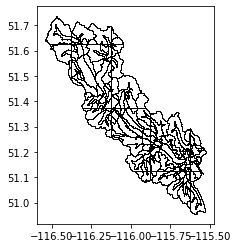

In [22]:
# Check what we got back
intersected_shape.plot(facecolor='none',edgecolor='k')

In [23]:
# Check the shape fields
intersected_shape

,S_1_GRU_ID,S_1_HRU_ID,S_1_center_lat,S_1_center_lon,S_1_HRU_area,S_1_lon_c,S_1_lat_c,AS1,IDS1,S_2_ID,...,S_2_lon,S_2_elev_m,AS2,IDS2,geometry,AINT,AP1,AP2,AP1N,AP2N
0,71028585,48,51.151817,-115.580275,5.081262e+05,-115.580275,51.151817,0.000065,1.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.57375 51.15042, -115.57375 51.1...",0.000065,1.000000,0.001044,1.000000,0.006580
1,71028585,97,51.160432,-115.575117,1.615975e+06,-115.575117,51.160432,0.000208,2.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554...",0.000208,1.000000,0.003322,1.000000,0.020931
2,71028585,118,51.172348,-115.572209,4.117252e+06,-115.572209,51.172348,0.000529,3.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.58792 51.17708, -115.58792 51.1...",0.000529,1.000000,0.008467,1.000000,0.053342
4,71028597,1,51.192711,-115.622019,1.620257e+06,-115.622019,51.192711,0.000208,4.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854...",0.000097,0.466667,0.001556,0.466667,0.009800
6,71028597,49,51.177476,-115.611405,3.781836e+06,-115.611405,51.177476,0.000486,5.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845...",0.000406,0.834286,0.006489,0.834286,0.040881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,71032185,91,51.586643,-116.376476,1.544394e+07,-116.376476,51.586643,0.002003,108.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.44208 51.58208, -116.4420...",0.000948,0.473128,0.015161,0.473128,0.108949
212,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.37500 51.62458, -116.3754...",0.000279,0.024671,0.004458,0.024671,0.032038
186,71032185,42,51.593968,-116.424058,5.606903e+07,-116.424058,51.593968,0.007272,107.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.44875 51.63458, -116.44708 51.6...",0.000321,0.044118,0.005133,0.044118,0.025529
211,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.47042 51.73542, -116.46708 51.7...",0.010346,0.916026,0.165536,0.916026,0.823233


In [24]:
intersected_shape.columns

Index(['S_1_GRU_ID', 'S_1_HRU_ID', 'S_1_center_lat', 'S_1_center_lon',
       'S_1_HRU_area', 'S_1_lon_c', 'S_1_lat_c', 'AS1', 'IDS1', 'S_2_ID',
       'S_2_lat', 'S_2_lon', 'S_2_elev_m', 'AS2', 'IDS2', 'geometry', 'AINT',
       'AP1', 'AP2', 'AP1N', 'AP2N'],
      dtype='object')

#### Save the new file

In [23]:
# As a shapefile - record of what we did
intersected_shape.to_file( intersect_path/intersect_name )

In [ ]:
# Remove
intersected_shape = intersected_shape.drop(columns=['S_1_center_lat','S_1_center_lon','S_1_HRU_area',
                                                    'AS1','IDS1',
                                                    'AS2','IDS2',
                                                    'geometry'])

In [ ]:
# As a .csv without the geometries


#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [35]:
# Set the log path and file name
logPath = intersect_path
log_suffix = '_catchment_forcing_intersect_log.txt'

In [36]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [39]:
# Copy this script
thisFile = '1_intersect_catchment_with_era5.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [40]:
# Get current date and time
now = datetime.now()

In [41]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Intersect shapefiles of catchment and ERA5.']
    for txt in lines:
        file.write(txt)  

#### Possible future code
Needs to wait until CANDEX functions are modified.

In [25]:
# Make an empty CANDEX object
cndx = candex.candex()

In [26]:
# List all methods
object_methods = [method_name for method_name in dir(cndx) if callable(getattr(cndx, method_name))]
object_methods

['NetCDF_SHP_lat_lon',
 '__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_candex__target_nc_creation',
 '_candex__weighted_average',
 'add_lat_lon_source_SHP',
 'check_candex_input',
 'check_candex_remap',
 'check_source_nc',
 'check_source_nc_shp',
 'check_target_shp',
 'create_remap',
 'create_row_col_df',
 'expand_source_SHP',
 'get_col_row',
 'intersection_shp',
 'lat_lon_SHP',
 'run_candex',
 'spatial_overlays']

In [27]:
# Get the function we need
func_intersect = getattr(cndx, 'intersection_shp')

In [30]:
intersected_shape

,S_1_GRU_ID,S_1_HRU_ID,S_1_center_lat,S_1_center_lon,S_1_HRU_area,S_1_lon_c,S_1_lat_c,AS1,IDS1,S_2_ID,...,S_2_lon,S_2_elev_m,AS2,IDS2,geometry,AINT,AP1,AP2,AP1N,AP2N
0,71028585,48,51.151817,-115.580275,5.081262e+05,-115.580275,51.151817,0.000065,1.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.57375 51.15042, -115.57375 51.1...",0.000065,1.000000,0.001044,1.000000,0.006580
1,71028585,97,51.160432,-115.575117,1.615975e+06,-115.575117,51.160432,0.000208,2.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554...",0.000208,1.000000,0.003322,1.000000,0.020931
2,71028585,118,51.172348,-115.572209,4.117252e+06,-115.572209,51.172348,0.000529,3.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.58792 51.17708, -115.58792 51.1...",0.000529,1.000000,0.008467,1.000000,0.053342
4,71028597,1,51.192711,-115.622019,1.620257e+06,-115.622019,51.192711,0.000208,4.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854...",0.000097,0.466667,0.001556,0.466667,0.009800
6,71028597,49,51.177476,-115.611405,3.781836e+06,-115.611405,51.177476,0.000486,5.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845...",0.000406,0.834286,0.006489,0.834286,0.040881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,71032185,91,51.586643,-116.376476,1.544394e+07,-116.376476,51.586643,0.002003,108.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.44208 51.58208, -116.4420...",0.000948,0.473128,0.015161,0.473128,0.108949
212,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.37500 51.62458, -116.3754...",0.000279,0.024671,0.004458,0.024671,0.032038
186,71032185,42,51.593968,-116.424058,5.606903e+07,-116.424058,51.593968,0.007272,107.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.44875 51.63458, -116.44708 51.6...",0.000321,0.044118,0.005133,0.044118,0.025529
211,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.47042 51.73542, -116.46708 51.7...",0.010346,0.916026,0.165536,0.916026,0.823233


In [28]:
catchment_shape

,GRU_ID,HRU_ID,center_lat,center_lon,HRU_area,geometry
0,71028585,48,51.151817,-115.580275,5.081262e+05,"POLYGON ((-115.57375 51.15042, -115.57375 51.1..."
1,71028585,97,51.160432,-115.575117,1.615975e+06,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554..."
2,71028585,118,51.172348,-115.572209,4.117252e+06,"POLYGON ((-115.58792 51.17708, -115.58792 51.1..."
3,71028597,1,51.192711,-115.622019,1.620257e+06,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854..."
4,71028597,49,51.177476,-115.611405,3.781836e+06,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845..."
...,...,...,...,...,...,...
113,71032409,94,51.639217,-116.148348,5.102856e+06,"MULTIPOLYGON (((-116.17708 51.66042, -116.1754..."
114,71032422,46,51.672291,-116.303021,4.762968e+07,"POLYGON ((-116.34125 51.71542, -116.34042 51.7..."
115,71032422,95,51.647877,-116.323133,3.299651e+06,"POLYGON ((-116.31875 51.63208, -116.31875 51.6..."
116,71032440,47,51.667536,-116.451110,8.694081e+07,"POLYGON ((-116.47042 51.73542, -116.46708 51.7..."


In [29]:
forcing_shape

,ID,lat,lon,elev_m,geometry
0,1.0,51.75,-116.75,2054,"POLYGON ((-116.87500 51.75000, -116.87500 51.8..."
1,2.0,51.50,-116.75,1895,"POLYGON ((-116.87500 51.50000, -116.87500 51.6..."
2,3.0,51.25,-116.75,1757,"POLYGON ((-116.87500 51.25000, -116.87500 51.3..."
3,4.0,51.00,-116.75,1684,"POLYGON ((-116.87500 51.00000, -116.87500 51.1..."
4,5.0,50.75,-116.75,1906,"POLYGON ((-116.87500 50.75000, -116.87500 50.8..."
5,6.0,51.75,-116.50,2243,"POLYGON ((-116.62500 51.75000, -116.62500 51.8..."
6,7.0,51.50,-116.50,2093,"POLYGON ((-116.62500 51.50000, -116.62500 51.6..."
7,8.0,51.25,-116.50,1810,"POLYGON ((-116.62500 51.25000, -116.62500 51.3..."
8,9.0,51.00,-116.50,1637,"POLYGON ((-116.62500 51.00000, -116.62500 51.1..."
9,10.0,50.75,-116.50,1789,"POLYGON ((-116.62500 50.75000, -116.62500 50.8..."


In [ ]:
# Set the required ID's
cndx.

In [33]:
# Use the intersection function
intersect2 = func_intersect(catchment_shape, forcing_shape)

C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:770: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1']  = shp_1.area
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:782: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2'] = shp_2.area
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\candex\candex.py:860: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
C:\Users\wmk934\Anaconda3\envs\geospatialTools_qgis_candex\lib\site-packages\cande

In [34]:
intersect2

,S_1_GRU_ID,S_1_HRU_ID,S_1_center_lat,S_1_center_lon,S_1_HRU_area,AS1,IDS1,S_2_ID,S_2_lat,S_2_lon,S_2_elev_m,AS2,IDS2,geometry,AINT,AP1,AP2,AP1N,AP2N
0,71028585,48,51.151817,-115.580275,5.081262e+05,0.000065,1,28.0,51.25,-115.5,2020,0.0625,28,"POLYGON ((-115.57375 51.15042, -115.57375 51.1...",0.000065,1.000000,0.001044,1.000000,0.006580
1,71028585,97,51.160432,-115.575117,1.615975e+06,0.000208,2,28.0,51.25,-115.5,2020,0.0625,28,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554...",0.000208,1.000000,0.003322,1.000000,0.020931
2,71028585,118,51.172348,-115.572209,4.117252e+06,0.000529,3,28.0,51.25,-115.5,2020,0.0625,28,"POLYGON ((-115.58792 51.17708, -115.58792 51.1...",0.000529,1.000000,0.008467,1.000000,0.053342
4,71028597,1,51.192711,-115.622019,1.620257e+06,0.000208,4,28.0,51.25,-115.5,2020,0.0625,28,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854...",0.000097,0.466667,0.001556,0.466667,0.009800
6,71028597,49,51.177476,-115.611405,3.781836e+06,0.000486,5,28.0,51.25,-115.5,2020,0.0625,28,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845...",0.000406,0.834286,0.006489,0.834286,0.040881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,71032185,91,51.586643,-116.376476,1.544394e+07,0.002003,108,7.0,51.50,-116.5,2093,0.0625,7,"MULTIPOLYGON (((-116.44208 51.58208, -116.4420...",0.000948,0.473128,0.015161,0.473128,0.108949
212,71032440,47,51.667536,-116.451110,8.694081e+07,0.011294,117,7.0,51.50,-116.5,2093,0.0625,7,"MULTIPOLYGON (((-116.37500 51.62458, -116.3754...",0.000279,0.024671,0.004458,0.024671,0.032038
186,71032185,42,51.593968,-116.424058,5.606903e+07,0.007272,107,6.0,51.75,-116.5,2243,0.0625,6,"POLYGON ((-116.44875 51.63458, -116.44708 51.6...",0.000321,0.044118,0.005133,0.044118,0.025529
211,71032440,47,51.667536,-116.451110,8.694081e+07,0.011294,117,6.0,51.75,-116.5,2243,0.0625,6,"POLYGON ((-116.47042 51.73542, -116.46708 51.7...",0.010346,0.916026,0.165536,0.916026,0.823233


In [35]:
intersected_shape

,S_1_GRU_ID,S_1_HRU_ID,S_1_center_lat,S_1_center_lon,S_1_HRU_area,S_1_lon_c,S_1_lat_c,AS1,IDS1,S_2_ID,...,S_2_lon,S_2_elev_m,AS2,IDS2,geometry,AINT,AP1,AP2,AP1N,AP2N
0,71028585,48,51.151817,-115.580275,5.081262e+05,-115.580275,51.151817,0.000065,1.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.57375 51.15042, -115.57375 51.1...",0.000065,1.000000,0.001044,1.000000,0.006580
1,71028585,97,51.160432,-115.575117,1.615975e+06,-115.575117,51.160432,0.000208,2.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554...",0.000208,1.000000,0.003322,1.000000,0.020931
2,71028585,118,51.172348,-115.572209,4.117252e+06,-115.572209,51.172348,0.000529,3.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.58792 51.17708, -115.58792 51.1...",0.000529,1.000000,0.008467,1.000000,0.053342
4,71028597,1,51.192711,-115.622019,1.620257e+06,-115.622019,51.192711,0.000208,4.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854...",0.000097,0.466667,0.001556,0.466667,0.009800
6,71028597,49,51.177476,-115.611405,3.781836e+06,-115.611405,51.177476,0.000486,5.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845...",0.000406,0.834286,0.006489,0.834286,0.040881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,71032185,91,51.586643,-116.376476,1.544394e+07,-116.376476,51.586643,0.002003,108.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.44208 51.58208, -116.4420...",0.000948,0.473128,0.015161,0.473128,0.108949
212,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.37500 51.62458, -116.3754...",0.000279,0.024671,0.004458,0.024671,0.032038
186,71032185,42,51.593968,-116.424058,5.606903e+07,-116.424058,51.593968,0.007272,107.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.44875 51.63458, -116.44708 51.6...",0.000321,0.044118,0.005133,0.044118,0.025529
211,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.47042 51.73542, -116.46708 51.7...",0.010346,0.916026,0.165536,0.916026,0.823233


In [36]:
intersected_shape == intersect2

ValueError: Can only compare identically-labeled DataFrame objects